<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/LSTM%20Autoencoder/%EA%B0%9C%EC%84%A0%ED%8C%90_LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
#이 코드는 create_sequences를 통해 웨이퍼 한 개를 여러 조각(Window)으로 늘려 학습 데이터를 대량 확보하는 Silding window 방식을 사용하였습니다.
#학습에 쓴 웨이퍼의 데이터 조각은 절대로 테스트에 들어가지 않습니다. 즉 모델이 정말로 처음 보는 데이터에 강한지 확인합니다.
#10-Fold CV 같은 정제 과정 없이, LSTM AE가 정상 데이터를 얼마나 잘 학습하고 불량을 얼마나 잘 걸러내는지 원초적인 성능을 측정합니다.

# [1] 라이브러리 임포트 및 환경 설정

import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import drive

# 드라이브 마운트 및 장치 설정
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ 사용 중인 장치: {device}")

✅ 사용 중인 장치: cpu


In [18]:
# [2] 데이터 로드 및 초기 필터링

file_path = ("/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx")

if os.path.exists(file_path):
    df = pd.read_excel(file_path)
    print(f"✅ 데이터 로드 완료. Shape: {df.shape}")
else:
    raise FileNotFoundError(f"❌ 파일을 찾을 수 없습니다: {file_path}")

# 식별 컬럼 및 센서 컬럼 정의
meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']
sensor_cols = [c for c in df.columns if c not in meta_cols]
sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"✅ 선택된 센서 변수: {len(sensor_cols)}개")

✅ 데이터 로드 완료. Shape: (12829, 25)
✅ 선택된 센서 변수: 19개


In [19]:
# [3] 모델 및 유틸리티 함수 정의

# 1. 전처리 함수: Sliding Window 방식
def create_sequences(data, seq_len=100):
    sequences = []
    if len(data) < seq_len:
        return np.array([])
    for i in range(len(data) - seq_len + 1):
        sequences.append(data[i:i + seq_len])
    return np.array(sequences)

# 2. 결과 시각화 함수
def plot_model_results(exp_id, title, y_true, y_pred, ai_scores, threshold):
    plt.figure(figsize=(12, 4))

    # 혼동 행렬
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    plt.title(f'[{exp_id}] {title} CM')

    # AI 분포 (오차 분포)
    plt.subplot(1, 2, 2)
    indices = np.arange(len(ai_scores))
    n_norm = sum(y_true)
    plt.scatter(indices[:n_norm], ai_scores[:n_norm], color='blue', label='Healthy', alpha=0.5, s=10)
    plt.scatter(indices[n_norm:], ai_scores[n_norm:], color='red', marker='x', label='Defective', s=10)
    plt.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    plt.title(f'AI Score Distribution')
    plt.legend()

    plt.tight_layout()
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    print(f"👉 {exp_id} Accuracy: {acc*100:.2f}%")
    return acc

# 3. Stacked LSTM Autoencoder 모델 클래스
class LAM9600_LSTM_AE(nn.Module):
    def __init__(self, n_features, seq_len):
        super(LAM9600_LSTM_AE, self).__init__()
        self.seq_len = seq_len
        self.n_features = n_features

        # [Encoder]
        self.encoder_lstm1 = nn.LSTM(n_features, 64, batch_first=True)
        self.encoder_lstm2 = nn.LSTM(64, 32, batch_first=True)
        self.encoder_lstm3 = nn.LSTM(32, 16, batch_first=True)

        # [Decoder]
        self.decoder_lstm1 = nn.LSTM(16, 32, batch_first=True)
        self.decoder_lstm2 = nn.LSTM(32, 64, batch_first=True)
        self.output_layer = nn.Linear(64, n_features)

    def forward(self, x):
        enc1, _ = self.encoder_lstm1(x)
        enc2, _ = self.encoder_lstm2(enc1)
        _, (hidden, _) = self.encoder_lstm3(enc2) # hidden: (1, batch, 16)

        # Repeat Vector: (batch, 100, 16)
        repeat_x = hidden.repeat(self.seq_len, 1, 1).permute(1, 0, 2)

        dec1, _ = self.decoder_lstm1(repeat_x)
        dec2, _ = self.decoder_lstm2(dec1)
        return self.output_layer(dec2)


🚀 l29 실험 분석 시작 (LSTM AE 순수 성능 평가)
📊 구성: Train_Win(2670), Test_Norm_Win(618), Test_Fault_Win(814)
Epoch [40/120], Loss: 0.030639
Epoch [80/120], Loss: 0.014629
Epoch [120/120], Loss: 0.012953


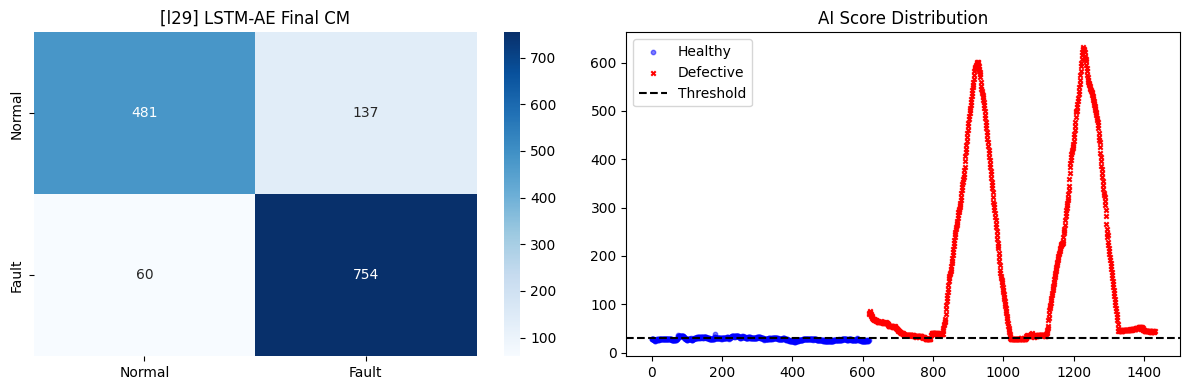

👉 l29 Accuracy: 86.24%

🚀 l31 실험 분석 시작 (LSTM AE 순수 성능 평가)
📊 구성: Train_Win(2727), Test_Norm_Win(713), Test_Fault_Win(443)
Epoch [40/120], Loss: 0.033954
Epoch [80/120], Loss: 0.033876
Epoch [120/120], Loss: 0.016808


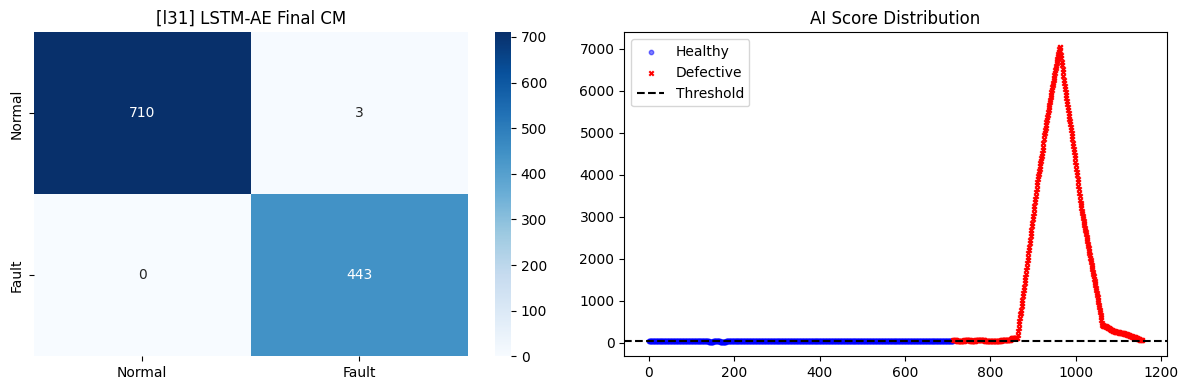

👉 l31 Accuracy: 99.74%

🚀 l33 실험 분석 시작 (LSTM AE 순수 성능 평가)
📊 구성: Train_Win(2761), Test_Norm_Win(687), Test_Fault_Win(505)
Epoch [40/120], Loss: 0.033544
Epoch [80/120], Loss: 0.033197
Epoch [120/120], Loss: 0.033532


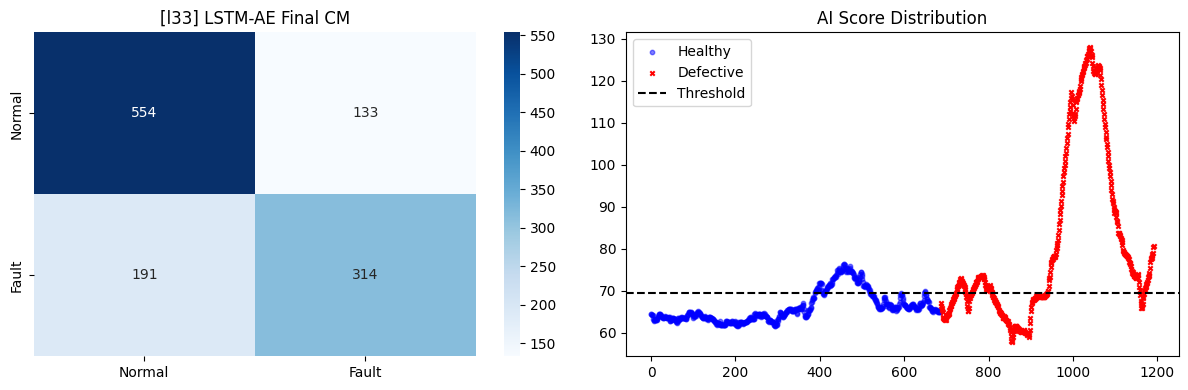

👉 l33 Accuracy: 72.82%


In [12]:
# [4] 메인 실험 루프 (학습 및 평가)
# ==========================================
experiments = ['l29', 'l31', 'l33']
all_results = []

for exp_id in experiments:
    print(f"\n" + "="*50)
    print(f"🚀 {exp_id} 실험 분석 시작 (LSTM AE 순수 성능 평가)")
    print("="*50)

    # 1. 해당 실험 데이터 추출 및 웨이퍼 기반 분리 (8:2)
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False)]
    normal_wafers = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()

    np.random.seed(42)
    train_wafer_count = int(len(normal_wafers) * 0.8)
    train_wafer_ids = np.random.choice(normal_wafers, train_wafer_count, replace=False)
    test_normal_wafer_ids = np.array([wid for wid in normal_wafers if wid not in train_wafer_ids])

    # 2. Raw 데이터 추출
    train_raw = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)][sensor_cols].values
    test_norm_raw = exp_df[exp_df['Wafer_ID'].isin(test_normal_wafer_ids)][sensor_cols].values
    test_fault_raw = exp_df[exp_df['Label'] == 'Fault'][sensor_cols].values

    # 3. 정규화 (학습 데이터 기준)
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_raw)
    test_norm_scaled = scaler.transform(test_norm_raw)
    test_fault_scaled = scaler.transform(test_fault_raw)

    # 4. 시퀀스 생성 (Sliding Window)
    X_train = create_sequences(train_scaled, seq_len=100)
    X_test_normal = create_sequences(test_norm_scaled, seq_len=100)
    X_test_fault = create_sequences(test_fault_scaled, seq_len=100)

    if X_train.size == 0:
        print(f"⚠️ {exp_id} 학습 데이터가 부족합니다. 건너뜁니다.")
        continue

    print(f"📊 구성: Train_Win({len(X_train)}), Test_Norm_Win({len(X_test_normal)}), Test_Fault_Win({len(X_test_fault)})")

    # 5. 모델 생성 및 학습
    model = LAM9600_LSTM_AE(len(sensor_cols), 100).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train).to(device)), batch_size=32, shuffle=True)

    model.train()
    for epoch in range(120): # LSTM 성능을 위한 충분한 학습
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(batch[0]), batch[0])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 40 == 0:
            print(f"Epoch [{epoch+1}/120], Loss: {epoch_loss/len(train_loader):.6f}")

    # 6. 추론 및 임계값 설정
    model.eval()
    with torch.no_grad():
        # 임계값 설정을 위한 학습 오차 (상위 5% 지점)
        train_recon = model(torch.FloatTensor(X_train).to(device))
        train_loss = torch.sum((torch.FloatTensor(X_train).to(device) - train_recon)**2, dim=(1, 2)).cpu().numpy()
        threshold = np.percentile(train_loss, 95)

        # 테스트 수행
        test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)
        test_tensor = torch.FloatTensor(test_all).to(device)
        test_recon = model(test_tensor)
        test_loss = torch.sum((test_tensor - test_recon)**2, dim=(1, 2)).cpu().numpy()

        y_true = [1]*len(X_test_normal) + [0]*len(X_test_fault)
        y_pred = [1 if err <= threshold else 0 for err in test_loss]

    # 7. 결과 시각화 및 기록
    acc = plot_model_results(exp_id, "LSTM-AE Final", y_true, y_pred, test_loss, threshold)
    all_results.append({'Exp': exp_id, 'Accuracy': acc})

In [13]:
# [5] 최종 결과 요약
# ==========================================
print("\n" + "="*30)
print("🏆 Final Performance Summary")
print("="*30)
summary_df = pd.DataFrame(all_results)
print(summary_df.to_string(index=False))


🏆 Final Performance Summary
Exp  Accuracy
l29  0.862430
l31  0.997405
l33  0.728188


In [14]:
# 'all_results' 리스트를 데이터프레임으로 변환 (이미 요약 부분에서 수행했다면 생략 가능)
summary_df = pd.DataFrame(all_results)

# 1. 전체 실험의 평균 정확도 계산
avg_accuracy = summary_df['Accuracy'].mean()

# 2. 결과 출력
print("\n" + "="*30)
print(f"📊 모든 실험의 평균 정확도: {avg_accuracy*100:.2f}%")
print("="*30)


📊 모든 실험의 평균 정확도: 86.27%



🧹 l29 실험: 10-Fold CV 데이터 정제 및 학습 시작
🔍 10-Fold CV 정제 중... (원본 샘플 수: 2670)
✨ 정제 완료: 2670 -> 2400 (삭제된 노이즈: 270)
🏋️ 최종 모델 학습 시작 (100 Epochs)...
   Epoch [50/100], Loss: 0.030451
   Epoch [100/100], Loss: 0.030453


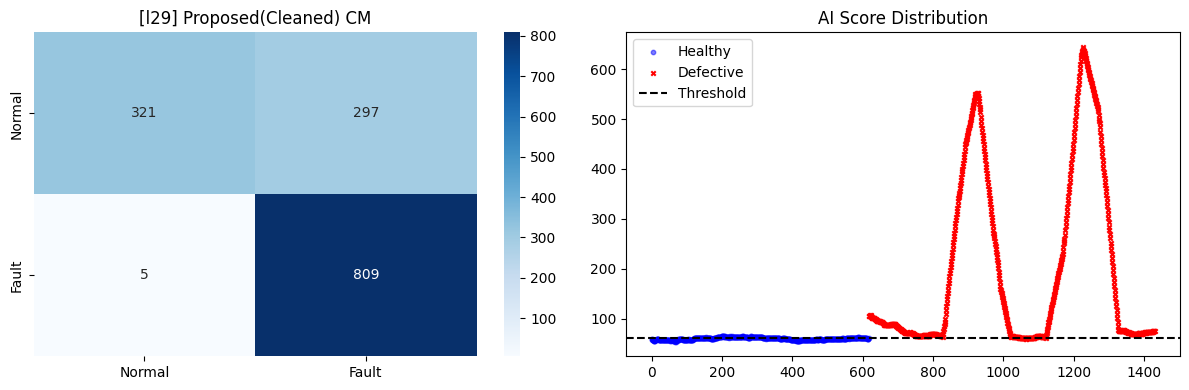

👉 l29 Accuracy: 78.91%

🧹 l31 실험: 10-Fold CV 데이터 정제 및 학습 시작
🔍 10-Fold CV 정제 중... (원본 샘플 수: 2727)
✨ 정제 완료: 2727 -> 2447 (삭제된 노이즈: 280)
🏋️ 최종 모델 학습 시작 (100 Epochs)...
   Epoch [50/100], Loss: 0.033520
   Epoch [100/100], Loss: 0.018501


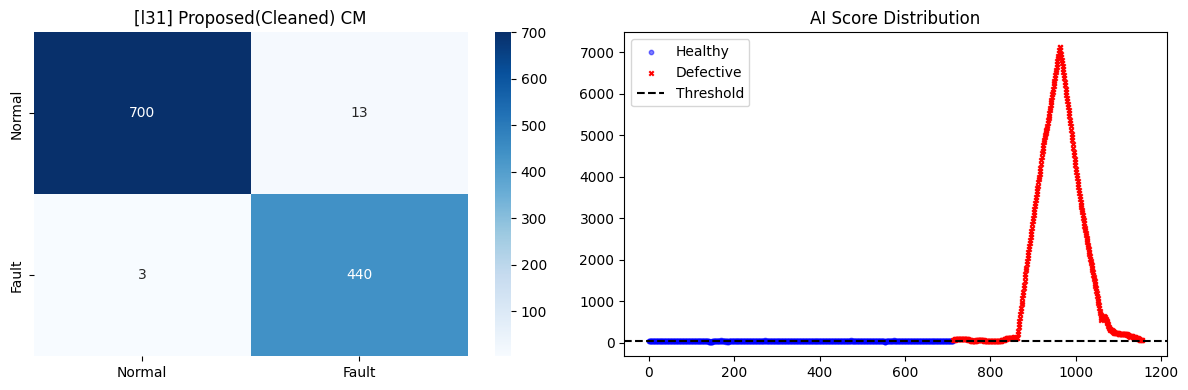

👉 l31 Accuracy: 98.62%

🧹 l33 실험: 10-Fold CV 데이터 정제 및 학습 시작
🔍 10-Fold CV 정제 중... (원본 샘플 수: 2761)
✨ 정제 완료: 2761 -> 2481 (삭제된 노이즈: 280)
🏋️ 최종 모델 학습 시작 (100 Epochs)...
   Epoch [50/100], Loss: 0.033181
   Epoch [100/100], Loss: 0.033188


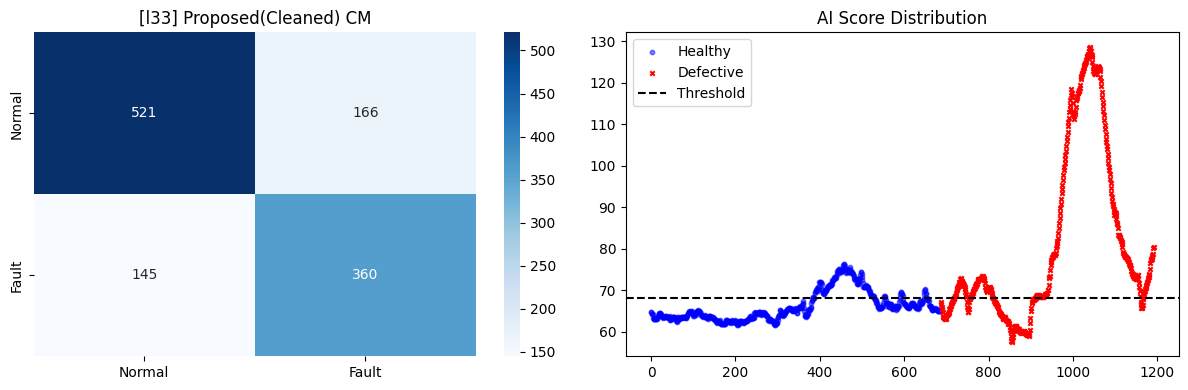

👉 l33 Accuracy: 73.91%

🏆 Proposed 모델 최종 평균 정확도: 83.81%
Exp  Accuracy
l29  0.789106
l31  0.986159
l33  0.739094


In [20]:
#모델 구현 이후 10-Fold CV를 적용한 경우의 학습 및 추론 결과
from sklearn.model_selection import KFold

# 실험 설정 (l29, l31, l33)
experiments = ['l29', 'l31', 'l33']
all_results_refined = []

# 실험별 정제 강도 설정 (clean_p: 오차가 큰 상위 몇 %를 버릴 것인가)
# 논문 기준에 따라 90% (상위 10% 제거)로 설정합니다.
clean_p = 90

for exp_id in experiments:
    print(f"\n" + "="*60)
    print(f"🧹 {exp_id} 실험: 10-Fold CV 데이터 정제 및 학습 시작")
    print("="*60)

    # 1. 해당 실험 데이터 추출 및 웨이퍼 기반 분리 (8:2)
    exp_df = df[df['Wafer_ID'].str.contains(exp_id, case=False)]
    normal_wafers = exp_df[exp_df['Label'] == 'Normal']['Wafer_ID'].unique()

    np.random.seed(42)
    train_wafer_count = int(len(normal_wafers) * 0.8)
    train_wafer_ids = np.random.choice(normal_wafers, train_wafer_count, replace=False)
    test_normal_wafer_ids = np.array([wid for wid in normal_wafers if wid not in train_wafer_ids])

    # 2. Raw 데이터 추출
    train_raw = exp_df[exp_df['Wafer_ID'].isin(train_wafer_ids)][sensor_cols].values
    test_norm_raw = exp_df[exp_df['Wafer_ID'].isin(test_normal_wafer_ids)][sensor_cols].values
    test_fault_raw = exp_df[exp_df['Label'] == 'Fault'][sensor_cols].values

    # 3. 정규화 및 시퀀스 생성
    scaler = MinMaxScaler()
    X_train_raw = create_sequences(scaler.fit_transform(train_raw), seq_len=100)
    X_test_normal = create_sequences(scaler.transform(test_norm_raw), seq_len=100)
    X_test_fault = create_sequences(scaler.transform(test_fault_raw), seq_len=100)

    # ---------------------------------------------------------
    # [Step 4-1] 10-Fold CV 기반 데이터 정제 (Cleaning Process)
    # ---------------------------------------------------------

    print(f"🔍 10-Fold CV 정제 중... (원본 샘플 수: {len(X_train_raw)})")
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    bad_indices = []

    for fold, (t_idx, v_idx) in enumerate(kf.split(X_train_raw)):
        # 정제용 임시 모델 학습 (빠른 정제를 위해 20에폭 수행)
        temp_model = LAM9600_LSTM_AE(len(sensor_cols), 100).to(device)
        temp_opt = optim.Adam(temp_model.parameters(), lr=1e-3)
        temp_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_raw[t_idx]).to(device)), batch_size=32, shuffle=True)

        temp_model.train()
        for _ in range(20):
            for b in temp_loader:
                temp_opt.zero_grad()
                loss = nn.MSELoss()(temp_model(b[0]), b[0])
                loss.backward(); temp_opt.step()

        # 검증 폴드 데이터의 재건축 오차 계산
        temp_model.eval()
        with torch.no_grad():
            X_v = torch.FloatTensor(X_train_raw[v_idx]).to(device)
            recon_v = temp_model(X_v)
            error_v = torch.sum((X_v - recon_v)**2, dim=(1, 2)).cpu().numpy()

            # 오차가 큰 상위 (100-clean_p)% 지점의 임계값 계산
            thresh_clean = np.percentile(error_v, clean_p)
            bad_indices.extend(v_idx[error_v > thresh_clean])

    # 중복 제거 후 오염된 데이터 삭제
    bad_indices = list(set(bad_indices))
    X_train_clean = np.delete(X_train_raw, bad_indices, axis=0)
    print(f"✨ 정제 완료: {len(X_train_raw)} -> {len(X_train_clean)} (삭제된 노이즈: {len(bad_indices)})")

    # ---------------------------------------------------------
    # [Step 4-2] 최종 Proposed 모델 학습 (정제된 데이터 활용)
    # ---------------------------------------------------------
    model_final = LAM9600_LSTM_AE(len(sensor_cols), 100).to(device)
    optimizer = optim.Adam(model_final.parameters(), lr=1e-3)
    final_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train_clean).to(device)), batch_size=32, shuffle=True)

    model_final.train()
    print(f"🏋️ 최종 모델 학습 시작 (100 Epochs)...")
    for epoch in range(100):
        epoch_loss = 0
        for b in final_loader:
            optimizer.zero_grad()
            loss = nn.MSELoss()(model_final(b[0]), b[0])
            loss.backward(); optimizer.step()
            epoch_loss += loss.item()
        if (epoch+1) % 50 == 0:
            print(f"   Epoch [{epoch+1}/100], Loss: {epoch_loss/len(final_loader):.6f}")

    # ---------------------------------------------------------
    # [Step 4-3] 추론 및 결과 시각화
    # ---------------------------------------------------------
    model_final.eval()
    with torch.no_grad():
        # 임계값 설정 (정제된 학습 데이터의 오차 분포 기준 상위 5%)
        train_recon = model_final(torch.FloatTensor(X_train_clean).to(device))
        train_loss = torch.sum((torch.FloatTensor(X_train_clean).to(device) - train_recon)**2, dim=(1, 2)).cpu().numpy()
        threshold = np.percentile(train_loss, 95)

        # 테스트 수행 (정상 웨이퍼 20% + 불량 웨이퍼 전체)
        test_all = np.concatenate([X_test_normal, X_test_fault], axis=0)
        test_tensor = torch.FloatTensor(test_all).to(device)
        test_recon = model_final(test_tensor)
        test_loss = torch.sum((test_tensor - test_recon)**2, dim=(1, 2)).cpu().numpy()

        y_true = [1]*len(X_test_normal) + [0]*len(X_test_fault)
        y_pred = [1 if err <= threshold else 0 for err in test_loss]

    # 시각화 및 결과 저장
    acc = plot_model_results(exp_id, "Proposed(Cleaned)", y_true, y_pred, test_loss, threshold)
    all_results_refined.append({'Exp': exp_id, 'Accuracy': acc})

# ==========================================
# [5] 최종 결과 요약 및 평균 정확도
# ==========================================
summary_df = pd.DataFrame(all_results_refined)
avg_acc = summary_df['Accuracy'].mean()

print("\n" + "="*40)
print(f"🏆 Proposed 모델 최종 평균 정확도: {avg_acc*100:.2f}%")
print("="*40)
print(summary_df.to_string(index=False))